In [1]:
import numpy as np
import matplotlib.pyplot as plt

def pad_with_zeros(array):

    original_shape = array.shape
    new_shape = (2 * original_shape[0] + 1, 2 * original_shape[1] + 1)
    padded_array = np.zeros(new_shape, dtype=array.dtype)
    padded_array[1:-1:2, 1:-1:2] = array
    return padded_array

In [2]:
def convolve2d(X, W, stride=1):
    X_shape = X.shape
    W_shape = W.shape
    output_shape = (
        (X_shape[0] - W_shape[0]) // stride + 1,
        (X_shape[1] - W_shape[1]) // stride + 1
    )
    output = np.zeros(output_shape)
    for i in range(0, output_shape[0] * stride, stride):
        for j in range(0, output_shape[1] * stride, stride):
            if i + W_shape[0] <= X.shape[0] and j + W_shape[1] <= X.shape[1]:
                output[i // stride, j // stride] = np.sum(X[i:i + W_shape[0], j:j + W_shape[1]] * W)
    return output

In [3]:
class UpConv:
    def __init__(self, kernel_size, learning_rate=0.005, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.kernel_size = kernel_size
        self.kernel = np.random.randn(*kernel_size) * np.sqrt(2. / 4.)
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m_dw = np.zeros_like(self.kernel)
        self.v_dw = np.zeros_like(self.kernel)

    def update_learning_rate(self, new_lr):
      self.learning_rate = new_lr

    def forward(self, x):
        in_height, in_width, in_channels = x.shape
        out_height = in_height * 2
        out_width = in_width * 2
        out_channels = in_channels
        self.input = x
        output = np.zeros((out_height, out_width, out_channels))
        rot_filter = np.rot90(self.kernel, 2)
        for c in range(out_channels):
            x_ = pad_with_zeros(x[:,:,c])
            output[:,:,c] = convolve2d(x_, rot_filter)

        return output

    def backward(self, grad_output):
        out_height, out_width, out_channels = grad_output.shape
        in_height = out_height // 2
        in_width = out_width // 2
        in_channels = out_channels//2

        grad_input = np.zeros((in_height, in_width, in_channels))
        grad_kernel = np.zeros(self.kernel_size)

        for c in range(in_channels):
            grad_input[:,:,c] = convolve2d(grad_output[:,:,c], self.kernel, stride=2)

        grad_kernel[0, 0] = np.sum(grad_output[0::2, 0::2, :in_channels] * self.input[:, :, :])
        grad_kernel[0, 1] = np.sum(grad_output[1::2, 0::2, :in_channels] * self.input[:, :, :])
        grad_kernel[1, 0] = np.sum(grad_output[0::2, 1::2, :in_channels] * self.input[:, :, :])
        grad_kernel[1, 1] = np.sum(grad_output[1::2, 1::2, :in_channels] * self.input[:, :, :])

        # Update Adam optimizer parameters
        self.m_dw = self.beta1 * self.m_dw + (1 - self.beta1) * grad_kernel
        self.v_dw = self.beta2 * self.v_dw + (1 - self.beta2) * (grad_kernel ** 2)

        # Bias correction
        m_dw_corrected = self.m_dw / (1 - self.beta1)
        v_dw_corrected = self.v_dw / (1 - self.beta2)

        # Update kernel
        self.kernel -= self.learning_rate * m_dw_corrected / (np.sqrt(v_dw_corrected) + self.epsilon)

        return grad_input

In [4]:
import numpy as np

class conv1x1:
    def __init__(self, in_channels, out_channels, learning_rate=0.005, beta1=0.9, beta2=0.999,epsilon=1e-8):
        self.weights = np.random.randn(out_channels, in_channels) * np.sqrt(2. / in_channels)
        self.biases = np.zeros(out_channels)
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        # Initialize Adam optimizer parameters
        self.m_dw = np.zeros_like(self.weights)
        self.v_dw = np.zeros_like(self.weights)
        self.m_db = np.zeros_like(self.biases)
        self.v_db = np.zeros_like(self.biases)

    def forward(self, input):
        self.input = input
        height, width, in_channels = input.shape
        input_reshaped = input.reshape(-1, in_channels)
        output_reshaped = input_reshaped @ self.weights.T + self.biases
        output = output_reshaped.reshape(height, width, -1)
        self.output = output
        return self.output

    def update_learning_rate(self, new_lr):
        self.learning_rate = new_lr

    def backward(self, dL_dout):

        height, width, out_channels = dL_dout.shape
        in_channels = self.input.shape[2]

        dL_dout_reshaped = dL_dout.reshape(-1, out_channels)
        input_reshaped = self.input.reshape(-1, in_channels)

        dL_dweights = dL_dout_reshaped.T @ input_reshaped
        dL_dbiases = dL_dout_reshaped.sum(axis=0)
        dL_dinput = dL_dout_reshaped @ self.weights

        # Update Adam optimizer parameters
        self.m_dw = self.beta1 * self.m_dw + (1 - self.beta1) * dL_dweights
        self.v_dw = self.beta2 * self.v_dw + (1 - self.beta2) * (dL_dweights ** 2)
        self.m_db = self.beta1 * self.m_db + (1 - self.beta1) * dL_dbiases
        self.v_db = self.beta2 * self.v_db + (1 - self.beta2) * (dL_dbiases ** 2)

        # Bias correction
        m_dw_corrected = self.m_dw / (1 - self.beta1)
        v_dw_corrected = self.v_dw / (1 - self.beta2)
        m_db_corrected = self.m_db / (1 - self.beta1)
        v_db_corrected = self.v_db / (1 - self.beta2)

        # Update weights and biases
        self.weights -= self.learning_rate * m_dw_corrected / (np.sqrt(v_dw_corrected) + self.epsilon)
        self.biases -= self.learning_rate * m_db_corrected / (np.sqrt(v_db_corrected) + self.epsilon)

        dL_dweights = dL_dweights.reshape(self.weights.shape)
        dL_dinput = dL_dinput.reshape(height, width, in_channels)

        return dL_dinput


In [5]:
class conv3x3:
    def __init__(self, out_channels, in_channels, padding=1, learning_rate=0.005, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.padding = padding
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        self.depthwise_weights = np.random.randn(in_channels, 3, 3) * np.sqrt(2. / (in_channels * 9))
        self.depthwise_biases = np.zeros(in_channels)

        # Initialize Adam optimizer parameters
        self.m_dw = np.zeros_like(self.depthwise_weights)
        self.v_dw = np.zeros_like(self.depthwise_weights)
        self.m_db = np.zeros_like(self.depthwise_biases)
        self.v_db = np.zeros_like(self.depthwise_biases)

        # 1x1 convolution for pointwise convolution
        self.pointwise_conv = conv1x1(in_channels, out_channels, learning_rate = learning_rate)

    def forward(self, input):
        self.input = input
        height, width, in_channels = input.shape

        # Apply padding
        if self.padding > 0:
            padded_input = np.pad(input, ((self.padding, self.padding), (self.padding, self.padding), (0, 0)), mode='constant')
        else:
            padded_input = input

        out_height = height + 2 * self.padding - 2
        out_width = width + 2 * self.padding - 2

        depthwise_output = np.zeros((out_height, out_width, in_channels))

        # Depthwise convolution
        for i in range(in_channels):
            for h in range(out_height):
                for w in range(out_width):
                    input_patch = padded_input[h:h+3, w:w+3, i]
                    depthwise_output[h, w, i] = np.sum(input_patch * self.depthwise_weights[i]) + self.depthwise_biases[i]

        output = self.pointwise_conv.forward(depthwise_output)

        return output

    def update_learning_rate(self, new_lr):
        self.learning_rate = new_lr
        self.pointwise_conv.update_learning_rate(new_lr)

    def backward(self, dL_dout):
        height, width, out_channels = dL_dout.shape
        in_channels = self.input.shape[2]
        dL_ddepthwise = self.pointwise_conv.backward(dL_dout)

        padded_input = np.pad(self.input, ((self.padding, self.padding), (self.padding, self.padding), (0, 0)), mode='constant')
        padded_dL_dinput = np.zeros_like(padded_input, dtype="float64")
        dL_ddepthwise_weights = np.zeros_like(self.depthwise_weights)
        dL_ddepthwise_biases = np.zeros_like(self.depthwise_biases)

        for i in range(in_channels):
            for h in range(dL_ddepthwise.shape[0]):
                for w in range(dL_ddepthwise.shape[1]):
                    input_patch = padded_input[h:h+3, w:w+3, i]
                    dL_ddepthwise_weights[i] += dL_ddepthwise[h, w, i] * input_patch
                    dL_ddepthwise_biases[i] += dL_ddepthwise[h, w, i]
                    padded_dL_dinput[h:h+3, w:w+3, i] += dL_ddepthwise[h, w, i] * self.depthwise_weights[i]

        # Remove padding from dL_dinput
        if self.padding > 0:
            dL_dinput = padded_dL_dinput[self.padding:-self.padding, self.padding:-self.padding, :]
        else:
            dL_dinput = padded_dL_dinput

        # Update Adam optimizer parameters
        self.m_dw = self.beta1 * self.m_dw + (1 - self.beta1) * dL_ddepthwise_weights
        self.v_dw = self.beta2 * self.v_dw + (1 - self.beta2) * (dL_ddepthwise_weights ** 2)
        self.m_db = self.beta1 * self.m_db + (1 - self.beta1) * dL_ddepthwise_biases
        self.v_db = self.beta2 * self.v_db + (1 - self.beta2) * (dL_ddepthwise_biases ** 2)

        # Bias correction
        m_dw_corrected = self.m_dw / (1 - self.beta1)
        v_dw_corrected = self.v_dw / (1 - self.beta2)
        m_db_corrected = self.m_db / (1 - self.beta1)
        v_db_corrected = self.v_db / (1 - self.beta2)

        # Update depthwise weights and biases
        self.depthwise_weights -= self.learning_rate * m_dw_corrected / (np.sqrt(v_dw_corrected) + self.epsilon)
        self.depthwise_biases -= self.learning_rate * m_db_corrected / (np.sqrt(v_db_corrected) + self.epsilon)

        return dL_dinput


In [6]:
class maxpool2:

    def forward(self,A_prev):

        ( n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
        self.last_input = A_prev
        f = 2
        stride = 2
        m=1
        #print("dfa",self.last_input.shape)
        n_H = int(1 + (n_H_prev - f) / stride)
        n_W = int(1 + (n_W_prev - f) / stride)
        n_C = n_C_prev

        A = np.zeros((n_H, n_W, n_C))

        for i in range(m):
            for h in range(n_H):
                for w in range(n_W):
                    for c in range (n_C):


                        vert_start = h * stride
                        vert_end = h * stride+ f
                        horiz_start = w * stride
                        horiz_end = w * stride + f


                        a_prev_slice = A_prev[vert_start:vert_end, horiz_start:horiz_end,c]



                        A[h, w, c] = np.max(a_prev_slice)
        return A
    def iterate_region(self,image):

        h,w,_=image.shape
        new_h=h//2
        new_w=w//2

        for i in range(new_h):
            for j in range(new_w):
                im_region = image[(i*2):(i*2+2),(j*2):(j*2+2)]
                yield im_region,i,j

    def backward(self,d_l_d_out):
        d_l_d_input=np.zeros(self.last_input.shape)

        for im_region,i,j in self.iterate_region(self.last_input):
            h,w,f = im_region.shape
            amax = np.max(im_region,axis=(0,1))

            for i2 in range(h):
                for j2 in range(w):
                    for f2 in range(f):
                        if im_region[i2,j2,f2] == amax[f2]:


                            d_l_d_input[i*2+i2,j*2+j2,f2] = d_l_d_out[i,j,f2]

        return d_l_d_input

In [7]:
import numpy as np

def resize(image, target_size):

    height, width, channels = image.shape
    new_height, new_width = target_size

    # Calculate scaling factors for each axis
    y_scale = new_height / height
    x_scale = new_width / width

    # Interpolation
    resized_image = np.zeros((new_height, new_width, channels))

    for i in range(new_height):
        for j in range(new_width):
            y, x = i / y_scale, j / x_scale
            y_low, x_low = int(np.floor(y)), int(np.floor(x))
            y_high, x_high = min(y_low + 1, height - 1), min(x_low + 1, width - 1)
            y_fraction, x_fraction = y - y_low, x - x_low

            # Bilinear interpolation for each channel
            for c in range(channels):
                top_left = image[y_low, x_low, c]
                top_right = image[y_low, x_high, c]
                bottom_left = image[y_high, x_low, c]
                bottom_right = image[y_high, x_high, c]

                top = top_left * (1 - x_fraction) + top_right * x_fraction
                bottom = bottom_left * (1 - x_fraction) + bottom_right * x_fraction

                resized_image[i, j, c] = top * (1 - y_fraction) + bottom * y_fraction

    return resized_image


In [8]:
class LeakyReLU:
    def __init__(self, alpha=0.01):
        self.alpha = alpha

    def forward(self, input):
        self.input = input
        return np.where(input > 0, input, self.alpha * input)

    def backward(self, dL_dout):
        dL_dinput = np.where(self.input > 0, 1, self.alpha)
        return dL_dout * dL_dinput

class Sigmoid:
    def forward(self, input):
        self.output = 1 / (1 + np.exp(-input))
        return self.output

    def backward(self, dL_dout):
        sigmoid_derivative = self.output * (1 - self.output)
        return dL_dout * sigmoid_derivative

In [9]:
class Encoder:
    def __init__(self, num_filters, n_c_prev,learning_rate = 0.005):
        self.conv1 = conv3x3(num_filters, n_c_prev,learning_rate = 0.005)
        self.conv2 = conv3x3(num_filters, num_filters,learning_rate = 0.005)
        self.pool = maxpool2()
        self.activation1 = LeakyReLU()  # Using Leaky ReLU
        self.activation2 = LeakyReLU()

    def forward(self, input):
        conv1_out = self.activation1.forward(self.conv1.forward(input))
        conv2_out = self.activation2.forward(self.conv2.forward(conv1_out))
        pool_out = self.pool.forward(conv2_out)
        return pool_out, conv2_out

    def update_learning_rate(self, new_lr):
        self.conv1.update_learning_rate(new_lr)
        self.conv2.update_learning_rate(new_lr)

    def backward(self, d_l_d_pool):
        d_l_d_conv2 = self.pool.backward(d_l_d_pool)
        d_l_d_conv2 = self.activation2.backward(d_l_d_conv2)
        d_l_d_conv1 = self.conv2.backward(d_l_d_conv2)
        d_l_d_conv1 = self.activation1.backward(d_l_d_conv1)
        d_l_d_input = self.conv1.backward(d_l_d_conv1)
        return d_l_d_input

class Decoder:
    def __init__(self, num_filters, n_c_prev,learning_rate = 0.005):
        self.upconv = UpConv((2, 2),learning_rate = learning_rate)
        self.conv1 = conv3x3(num_filters, 2 * n_c_prev,learning_rate = learning_rate)
        self.conv2 = conv3x3(num_filters, num_filters,learning_rate = learning_rate)
        self.activation1 = LeakyReLU()  # Using Leaky ReLU
        self.activation2 = LeakyReLU()

    def update_learning_rate(self, new_lr):
        self.upconv.update_learning_rate(new_lr)
        self.conv1.update_learning_rate(new_lr)
        self.conv2.update_learning_rate(new_lr)

    def forward(self, input, skip_connection):
        upconv_out = self.upconv.forward(input)
        skip_connection = resize(skip_connection, upconv_out.shape[:2])
        merged = np.concatenate((upconv_out, skip_connection), axis=-1)
        conv1_out = self.activation1.forward(self.conv1.forward(merged))
        conv2_out = self.activation2.forward(self.conv2.forward(conv1_out))
        return conv2_out

    def backward(self, d_l_d_conv2):
        d_l_d_conv2 = self.activation2.backward(d_l_d_conv2)
        d_l_d_conv2 = self.conv2.backward(d_l_d_conv2)
        d_l_d_conv1 = self.activation1.backward(d_l_d_conv2)
        d_l_d_conv1 = self.conv1.backward(d_l_d_conv1)
        d_l_d_skip = d_l_d_conv1[:, :, d_l_d_conv1.shape[2] // 2:]
        d_l_d_input = self.upconv.backward(d_l_d_conv1)
        return d_l_d_input, d_l_d_skip

In [10]:
class UNet:
    def __init__(self, num_filters, num_levels,learning_rate = 0.005):

        self.encoders = [Encoder(num_filters, 3,learning_rate = learning_rate)]
        for _ in range(num_levels - 1):
            self.encoders.append(Encoder(num_filters * 2, num_filters,learning_rate = learning_rate))
            num_filters *= 2

        self.bottleneck_conv1 = conv3x3(num_filters, num_filters,learning_rate = learning_rate)
        self.bottleneck_activation1 = LeakyReLU()
        self.bottleneck_conv2 = conv3x3(num_filters, num_filters,learning_rate = learning_rate)
        self.bottleneck_activation2 = LeakyReLU()

        self.decoders = []
        for i in range(num_levels - 1, 0, -1):
            self.decoders.append(Decoder(num_filters // 2, num_filters,learning_rate = learning_rate))
            num_filters //= 2
        self.decoders.append(Decoder(num_filters, num_filters,learning_rate = learning_rate))

        self.conv1x1 = conv1x1(num_filters,1,learning_rate = learning_rate)
        self.sigmoid = Sigmoid()

    def forward(self, input):

        skip_connections = []
        x = input

        #encoders
        for encoder in self.encoders:
            x, skip = encoder.forward(x)
            skip_connections.append(skip)

        skip_connections.reverse()

        x = self.bottleneck_activation1.forward(self.bottleneck_conv1.forward(x))
        x = self.bottleneck_activation2.forward(self.bottleneck_conv2.forward(x))

        #decoders
        for decoder, skip in zip(self.decoders, skip_connections):
            x = decoder.forward(x, skip)

        x = self.conv1x1.forward(x)
        x = self.sigmoid.forward(x)
        return x

    def backward(self, d_loss):
        d_out = d_loss
        d_skips = []

        d_out = self.sigmoid.backward(d_out)
        d_out = self.conv1x1.backward(d_out)

        #decoders
        for decoder in reversed(self.decoders):
            d_out,d_skip = decoder.backward(d_out)
            d_skips.append(d_skip)

        # bottleneck
        d_out = self.bottleneck_activation2.backward(d_out)
        d_out = self.bottleneck_conv2.backward(d_out)
        d_out = self.bottleneck_activation1.backward(d_out)
        d_out = self.bottleneck_conv1.backward(d_out)

        d_skips.reverse()
        #encoders
        for i,encoder in enumerate(reversed(self.encoders)):
            d_out = encoder.backward(d_out+resize(d_skips[i],d_out.shape[:2]))

    def update_learning_rate(self, new_lr):
      for encoder in self.encoders:
          encoder.update_learning_rate(new_lr)
      for decoder in self.decoders:
          decoder.update_learning_rate(new_lr)
      self.bottleneck_conv1.update_learning_rate(new_lr)
      self.bottleneck_conv2.update_learning_rate(new_lr)
      self.conv1x1.update_learning_rate(new_lr)

In [11]:
def dice_coefficient(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    dice = (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice

def IOU(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    iou = intersection / union
    return iou

In [12]:
class CosineAnnealingScheduler:
    def __init__(self, initial_lr, T_max, eta_min=0):
        self.initial_lr = initial_lr
        self.T_max = T_max
        self.eta_min = eta_min

    def get_lr(self, epoch):
        return self.eta_min + (self.initial_lr - self.eta_min) * (1 + np.cos(np.pi * epoch / self.T_max)) / 2

In [13]:
from PIL import Image
import cv2

img_size = 256

def load_image(image_path):
    with Image.open(image_path) as img:
        image_array = np.array(img)
        image_array = cv2.resize(image_array,(img_size,img_size))
    return image_array

image_path = "/content/drive/MyDrive/train/f9ea1a1159c33f39bbe5f18bb278d961188b40508277eab7c0b4b91219b37b5d/images/f9ea1a1159c33f39bbe5f18bb278d961188b40508277eab7c0b4b91219b37b5d.png"
train_img = load_image(image_path)
train_img=np.array((train_img[:,:,:3]))
if(len(train_img.shape) ==2):
    train_img = np.expand_dims(train_img,axis=-1)

In [14]:
import os
folder_path = "/content/drive/MyDrive/train/f9ea1a1159c33f39bbe5f18bb278d961188b40508277eab7c0b4b91219b37b5d/masks"
mask = np.zeros((img_size,img_size))
for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        with Image.open(image_path) as img:
            image_array = np.array(img)
            image_array = cv2.resize(image_array,(img_size,img_size))
            mask = np.maximum(mask,image_array)
mask = mask>0.5
mask = np.expand_dims(mask,axis=-1)*1.0

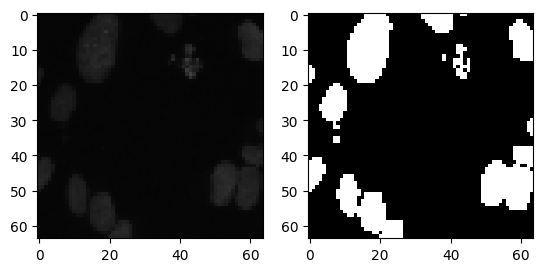

In [15]:
plt.subplot(121)
plt.imshow(train_img)
plt.subplot(122)
plt.imshow(mask,cmap = "gray")

In [16]:
learning_rate = 0.01
mynet = UNet(num_filters=64, num_levels=4,learning_rate = learning_rate)

In [17]:
# forward_pass = mynet.forward(train_img)

In [18]:
# forward_pass.shape

In [19]:
# scaled_img = cv2.resize(mask, (128, 128))
# scaled_mask = (scaled_img - np.min(scaled_img)) / (np.max(scaled_img) - np.min(scaled_img))
# scaled_mask = np.expand_dims(scaled_mask,axis = -1)
# epsilon = 1e-8
# dl = ((forward_pass - scaled_mask) / (forward_pass * (1 - forward_pass) + epsilon)) / scaled_mask.size

In [20]:
# mynet.backward(dl)

current lr = 0.01
Epoch: 0 Loss: 1.3334071730218757 Dice coefficient: 0.3346208578979467 IOU 0.200927734375


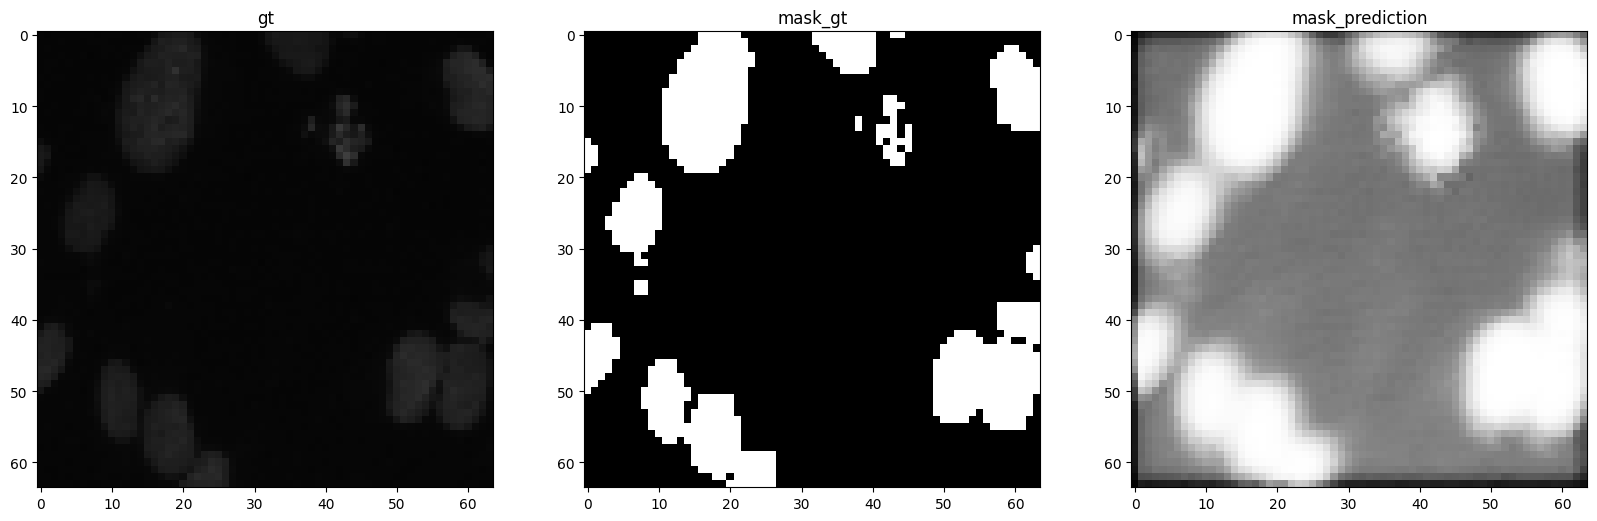

current lr = 0.009755282581475769
Epoch: 1 Loss: 0.7501080500758355 Dice coefficient: 0.33374133006935947 IOU 0.20029382957884426


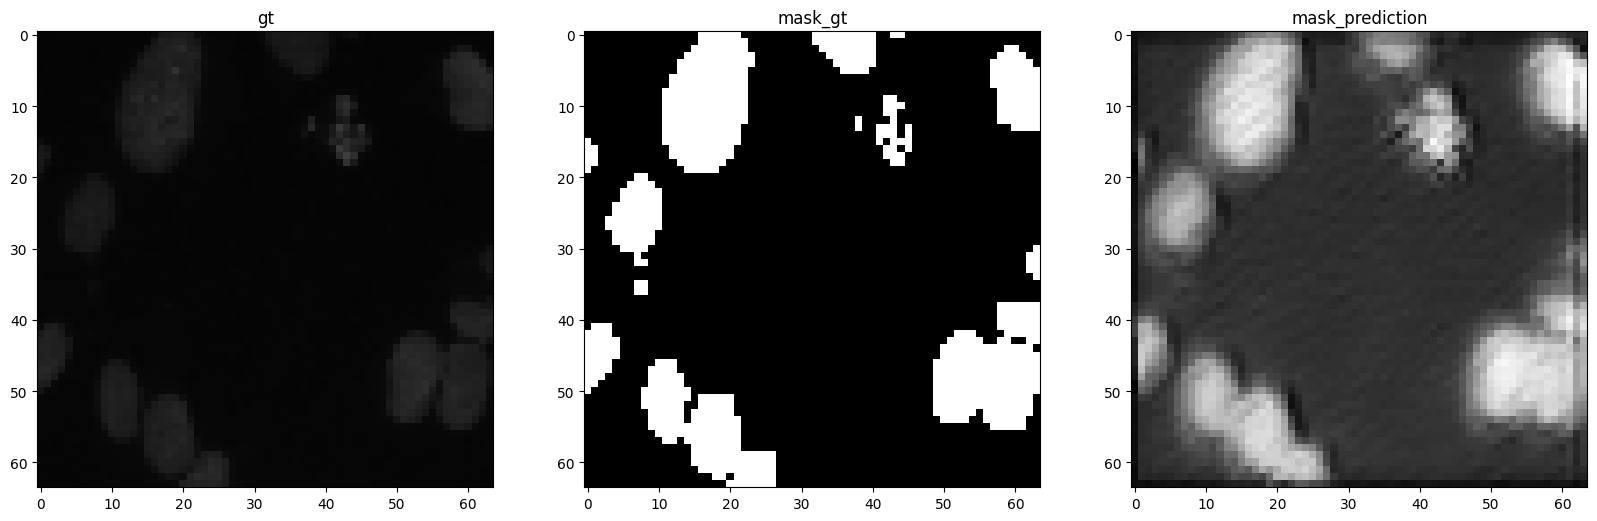

current lr = 0.009045084971874737
Epoch: 2 Loss: 0.6844477092834966 Dice coefficient: 0.46260683760683763 IOU 0.30090340514246006


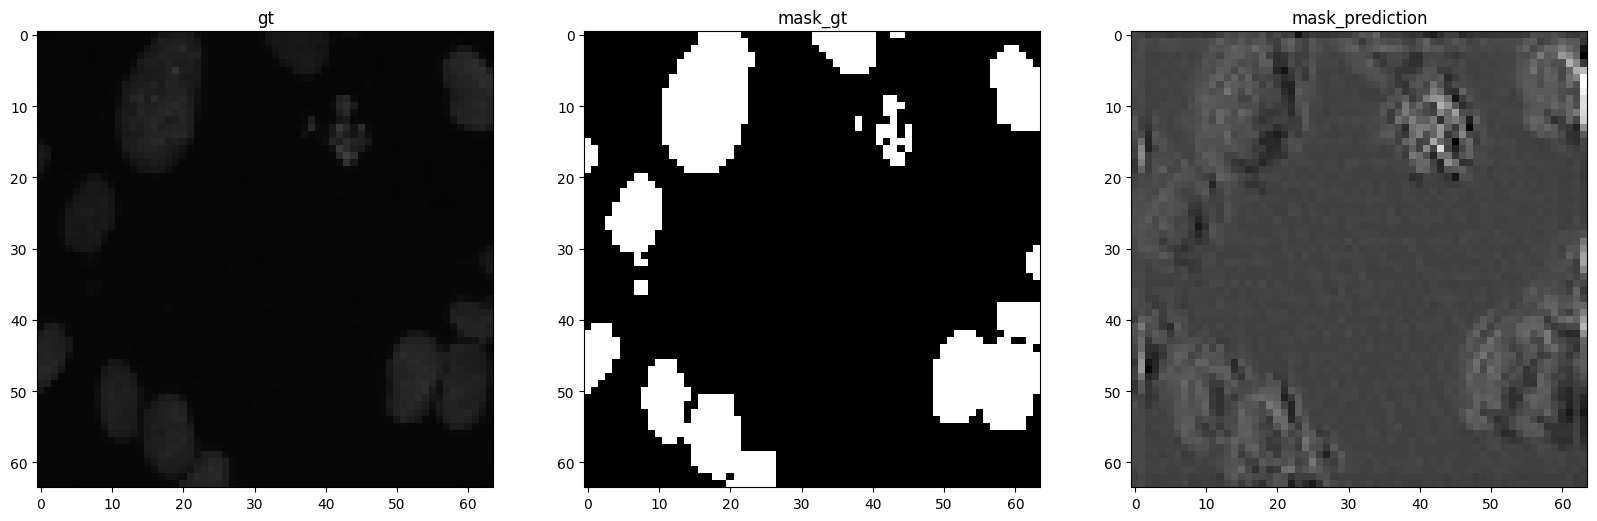

current lr = 0.007938926261462366
Epoch: 3 Loss: 0.6779345175825684 Dice coefficient: 0.12511848341232226 IOU 0.06673407482305359


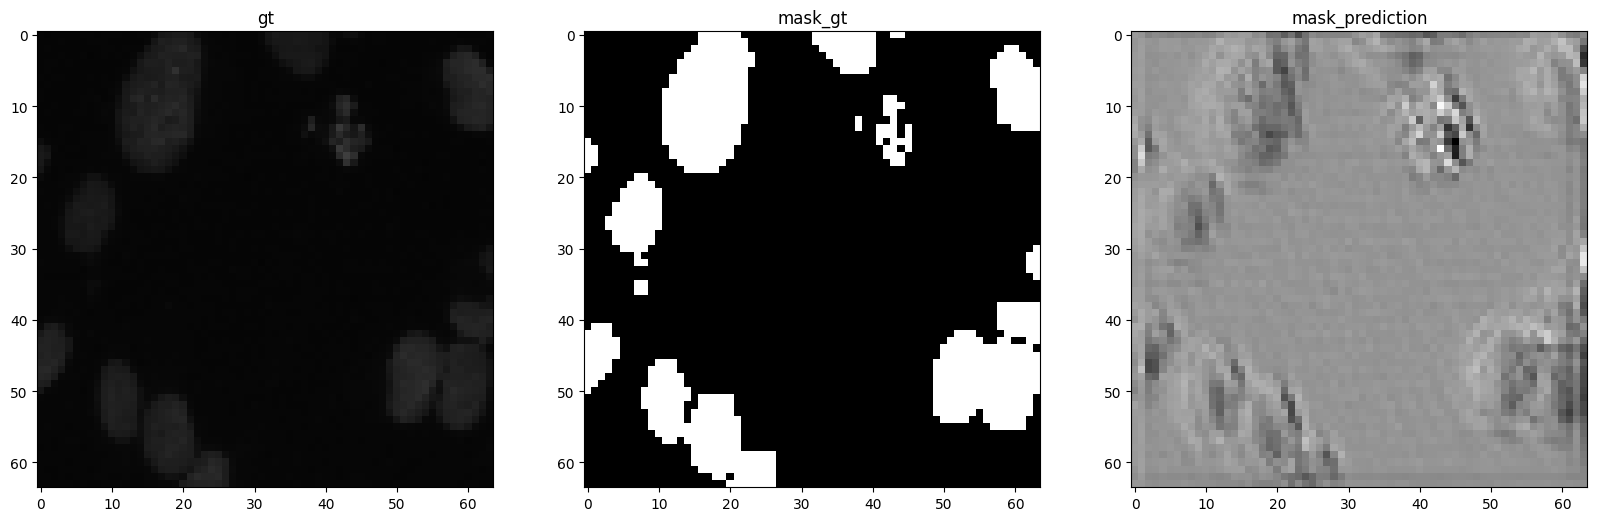

current lr = 0.006545084971874737
Epoch: 4 Loss: 0.6457023627602994 Dice coefficient: 0.06088992974238876 IOU 0.03140096618357488


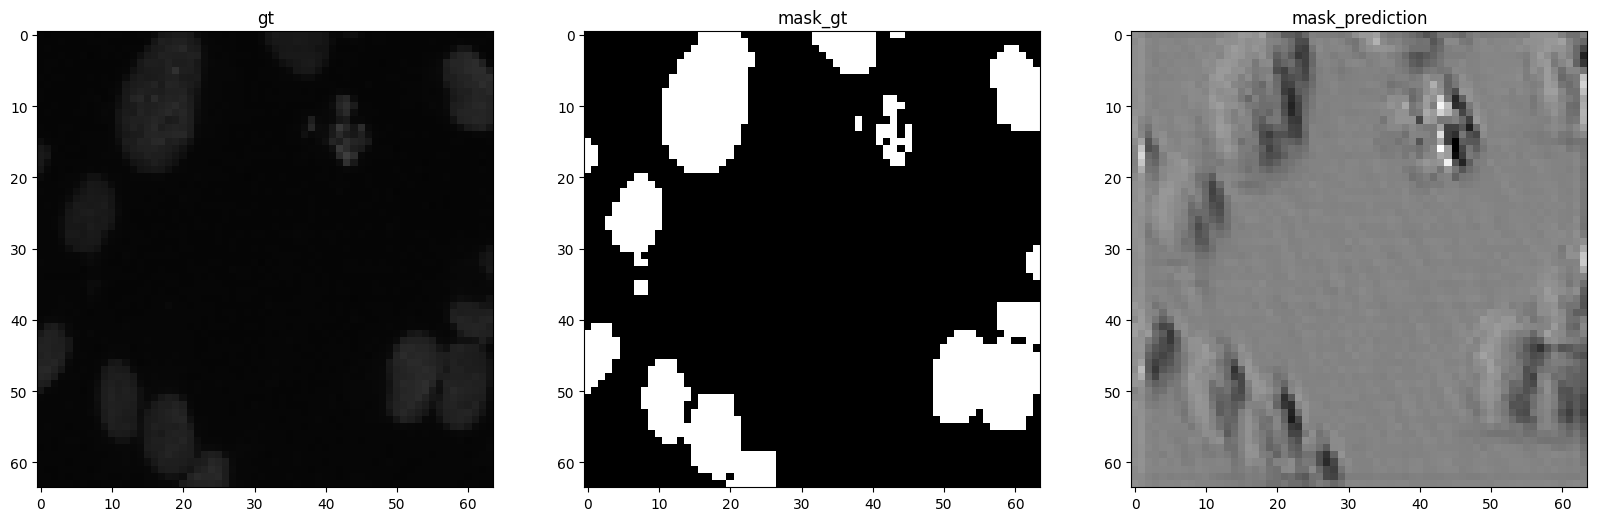

current lr = 0.005
Epoch: 5 Loss: 0.6140773538980459 Dice coefficient: 0.09436133486766399 IOU 0.049516908212560384


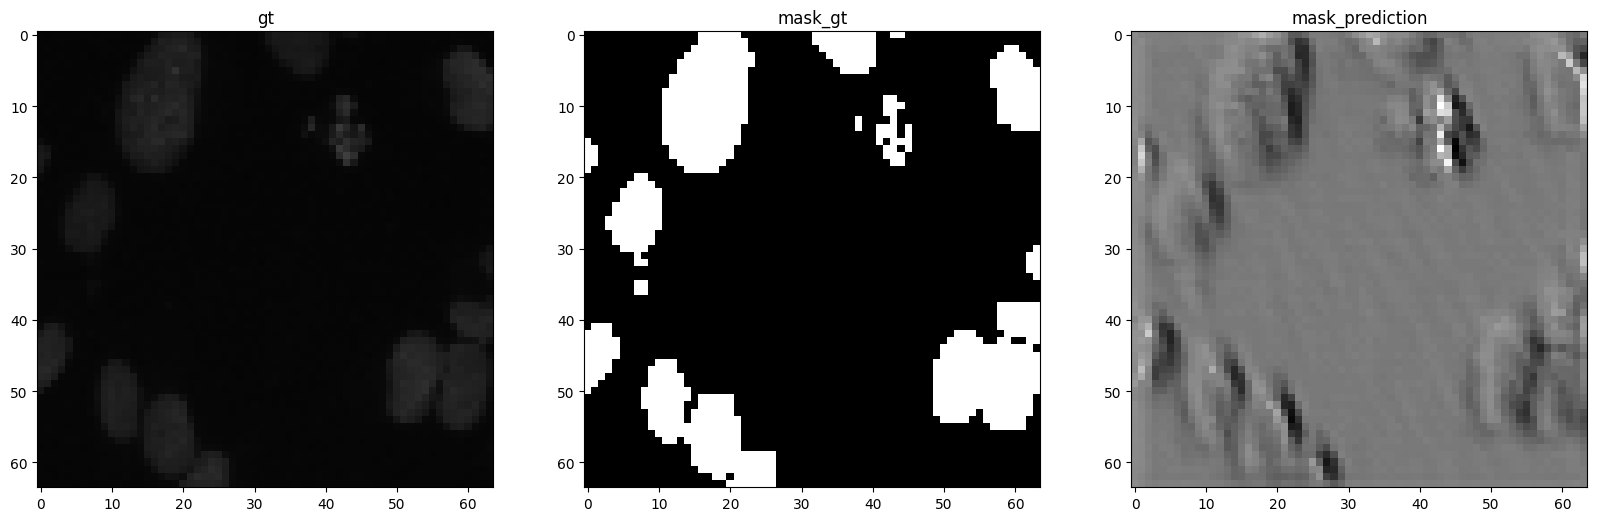

current lr = 0.003454915028125263
Epoch: 6 Loss: 0.5802071206478949 Dice coefficient: 0.23678646934460887 IOU 0.1342925659472422


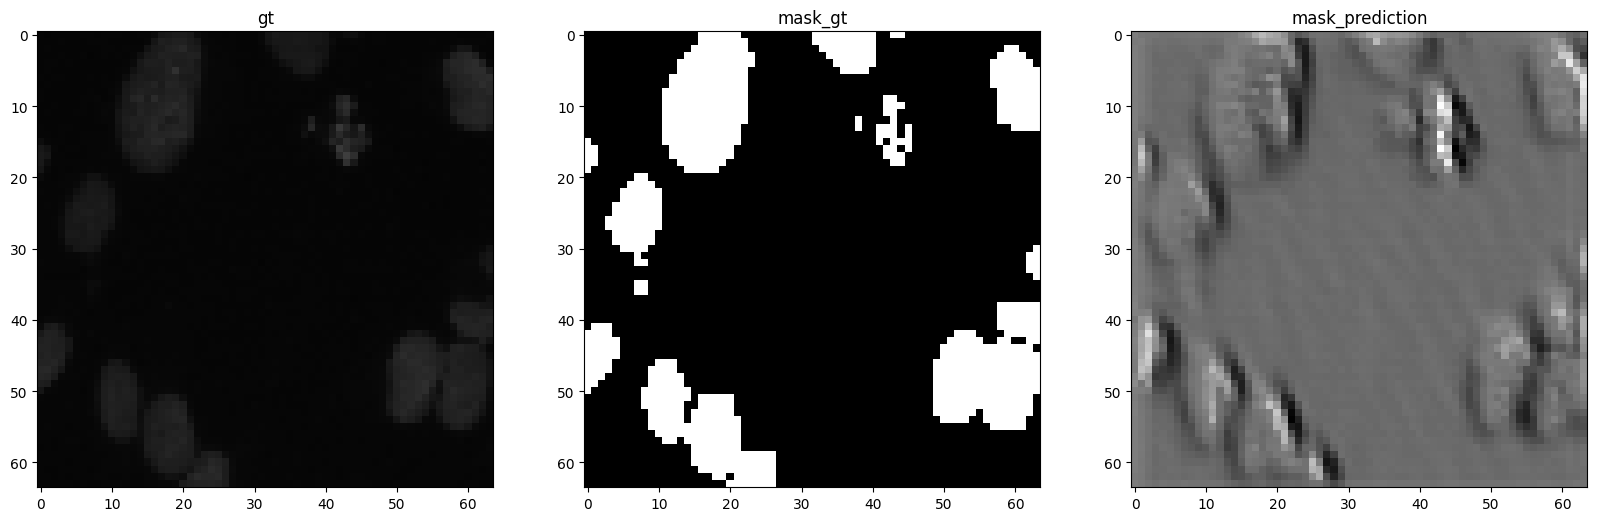

current lr = 0.0020610737385376348
Epoch: 7 Loss: 0.5389025569707603 Dice coefficient: 0.5843071786310517 IOU 0.41273584905660377


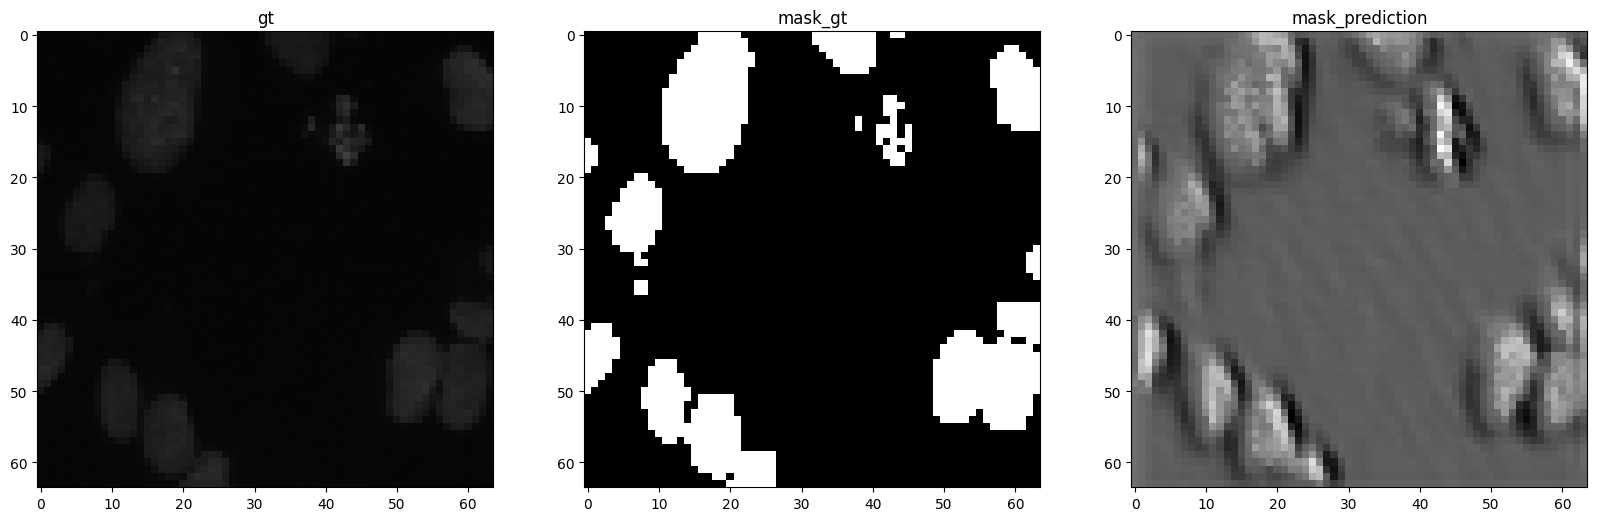

current lr = 0.0009549150281252633
Epoch: 8 Loss: 0.5067462731631382 Dice coefficient: 0.728486646884273 IOU 0.572928821470245


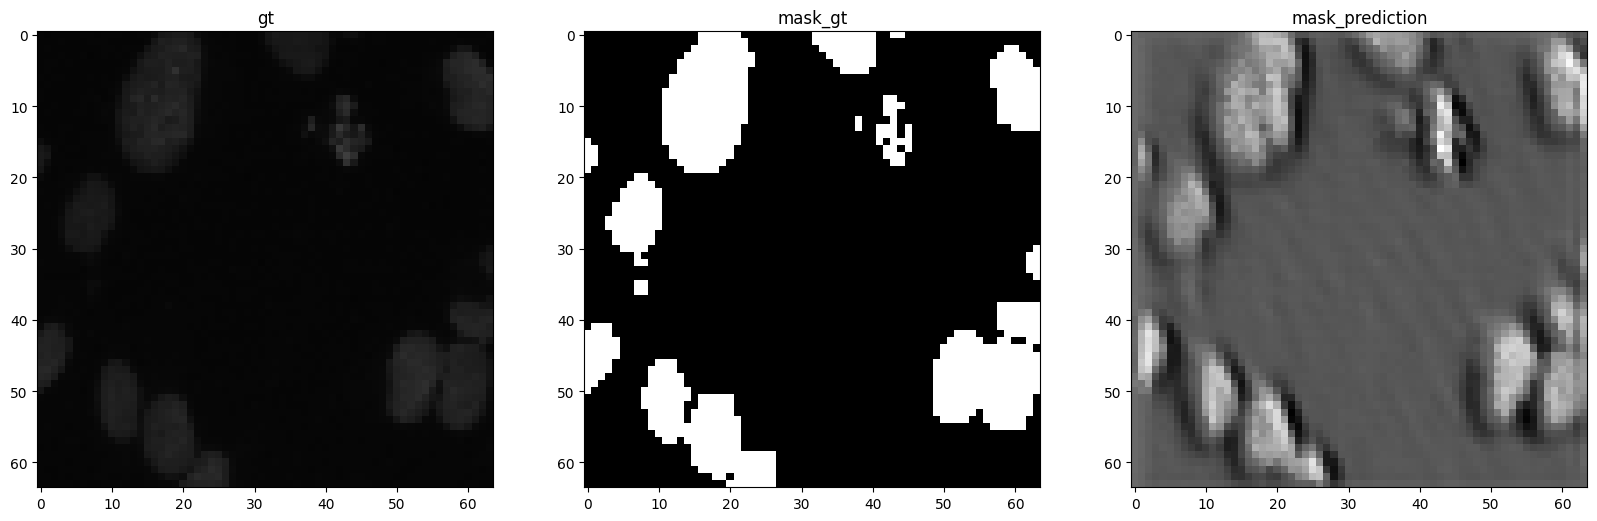

current lr = 0.00024471741852423234
Epoch: 9 Loss: 0.48887547497551403 Dice coefficient: 0.7510917030567685 IOU 0.6013986013986014


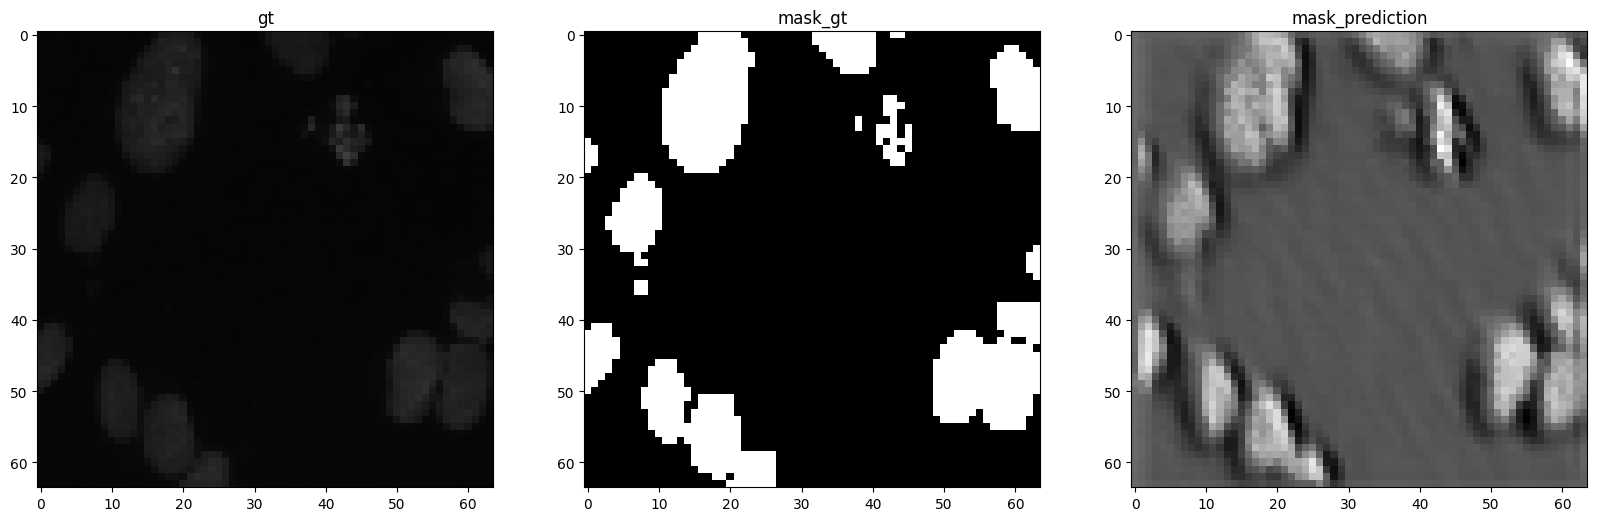

In [21]:
import cv2

epochs = 10

initial_lr = learning_rate
T_max = epochs  # This should typically be the number of epochs for one cycle
scheduler = CosineAnnealingScheduler(initial_lr, T_max)


# Concatenate the training image and mask, then resize and scale

scaled_img = cv2.resize(mask, (64, 64))
scaled_mask = (scaled_img - np.min(scaled_img)) / (np.max(scaled_img) - np.min(scaled_img))
scaled_mask = np.expand_dims(scaled_mask,axis = -1)
Loss = 1000000

for epoch in range(epochs):

  current_lr = scheduler.get_lr(epoch)
  print(f"current lr = {current_lr}")
  # Update learning rate in all layers
  mynet.update_learning_rate(current_lr)

  # Forward pass through the network
  forward_pass = mynet.forward(train_img)

  dice = dice_coefficient(scaled_mask,forward_pass)
  iou = IOU(scaled_mask,forward_pass)

  # Compute binary cross-entropy loss
  epsilon = 1e-12  # to avoid log(0)
  loss = -np.mean(scaled_mask * np.log(forward_pass + epsilon) + (1 - scaled_mask) * np.log(1 - forward_pass + epsilon))
  if(loss<Loss):
    Loss = loss
    best_prediction = forward_pass

  print("Epoch:", epoch, "Loss:", loss, "Dice coefficient:", dice, "IOU", iou)

  # Plotting
  plt.figure(figsize=(20, 30))
  plt.subplot(131)
  plt.imshow(train_img, cmap="gray")
  plt.title("gt")
  plt.subplot(132)
  plt.imshow(mask, cmap="gray")
  plt.title("mask_gt")
  plt.subplot(133)
  plt.imshow(cv2.resize(forward_pass,(mask.shape[0],mask.shape[1])), cmap="gray")
  plt.title("mask_prediction")
  plt.show()

  # Compute the gradient of BCE loss
  dl = ((forward_pass - scaled_mask) / (forward_pass * (1 - forward_pass) + epsilon)) / scaled_mask.size
  mynet.backward(dl)

  # Decrement epochs
  epochs -= 1


In [22]:
dice = dice_coefficient(mask,best_prediction)
iou = IOU(mask,best_prediction)

print(f"Dice loss:{dice}, IOU: {iou}")

Dice loss:0.7510917030567685, IOU: 0.6013986013986014


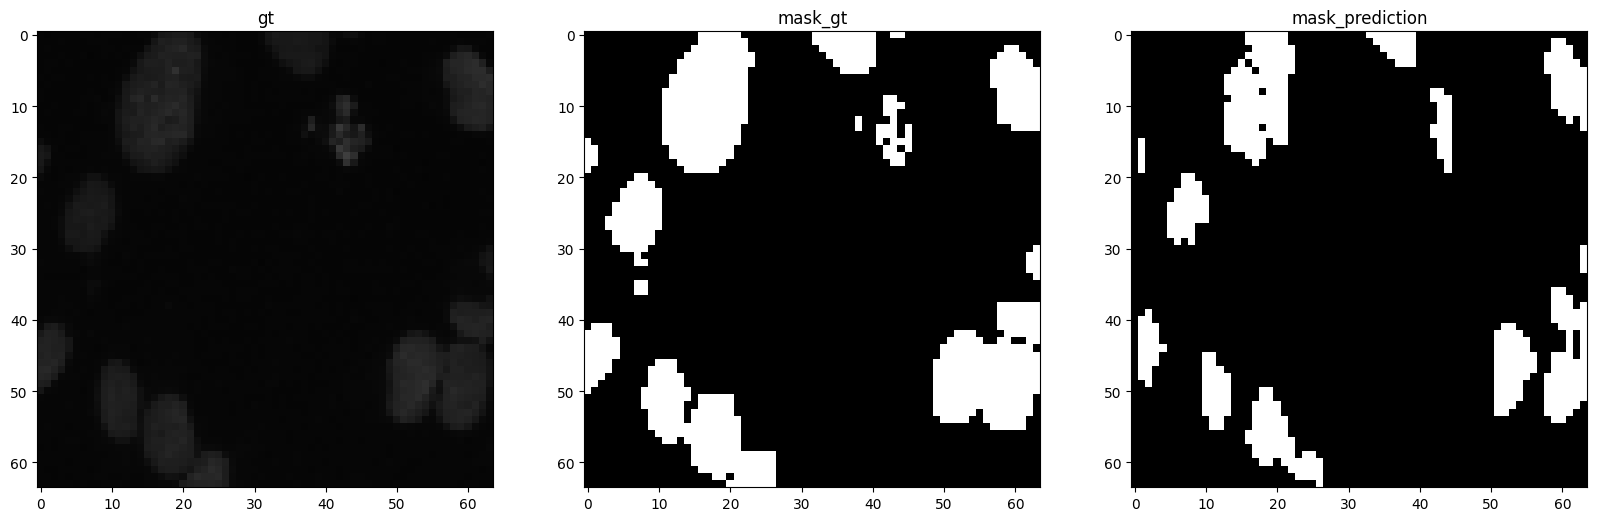

In [23]:
# Plotting
plt.figure(figsize=(20, 30))
plt.subplot(131)
plt.imshow(train_img, cmap="gray")
plt.title("gt")
plt.subplot(132)
plt.imshow(mask, cmap="gray")
plt.title("mask_gt")
plt.subplot(133)
plt.imshow(cv2.resize(forward_pass,(mask.shape[0],mask.shape[1]))>0.5, cmap="gray") #greater than 0.5 is = 1 else 0
plt.title("mask_prediction")
plt.show()